In [1]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.
# import kagglehub
# masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

# print('Data source import complete.')


In [38]:
# Data Handling
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import gc

# Image Processing
from PIL import Image, ImageEnhance
import cv2
from tensorflow.keras.preprocessing.image import load_img

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import *

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the Data

### Dataset paths

In [3]:
DIR ="/kaggle/input/brain-tumor-mri-dataset"
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"
train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"

### Hyperparameters

In [4]:
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 20
IMG_SIZE = 224
NUM_CLASSES = 4
lables = {
    "glioma" : 0,
    "meningioma" : 1,
    "notumor" : 2,
    "pituitary" : 3
}

### Reading the Dataset

In [5]:
Train = []
Train_labels = []
for label in os.listdir(train_path):
    for img in os.listdir(os.path.join(train_path, label)):
        Train.append((os.path.join(train_path, label, img), label))
        Train_labels.append(label)
Train, Train_labels = shuffle(Train, Train_labels, random_state=42)

Test = []
Test_labels = []
for label in os.listdir(test_path):
    for img in os.listdir(os.path.join(test_path, label)):
        Test.append((os.path.join(test_path, label, img), label))
        Test_labels.append(label)
Test, Test_labels = shuffle(Test, Test_labels, random_state=42)

### pie chart

Text(0.5, 1.0, 'Testing Set Distribution')

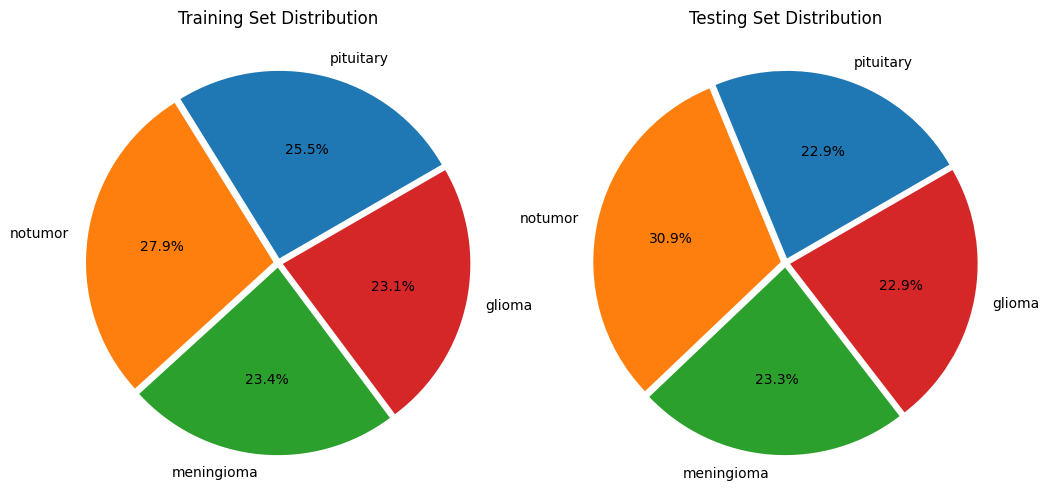

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Training Pie Chart
axs[0].pie([len([x for x in Train_labels if x=='pituitary']),
         len([x for x in Train_labels if x=='notumor']),
         len([x for x in Train_labels if x=='meningioma']),
         len([x for x in Train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
         autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);
axs[0].axis('equal')
axs[0].set_title("Training Set Distribution")

# Testing Pie Chart
axs[1].pie([len([x for x in Test_labels if x=='pituitary']),
         len([x for x in Test_labels if x=='notumor']),
         len([x for x in Test_labels if x=='meningioma']),
         len([x for x in Test_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
         autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);
axs[1].axis('equal')
axs[1].set_title("Testing Set Distribution")


### Encode labels

In [7]:
label_encoder = LabelEncoder()
Train_labels_encoded = label_encoder.fit_transform(Train_labels)
Test_labels_encoded = label_encoder.transform(Test_labels)

## 🔧 Augmentations Applied

| Augmentation    | Description                                                                                            |
| --------------- | ------------------------------------------------------------------------------------------------------ |
| `Brightness`    | Randomly increases or decreases brightness. Range: `0.8 – 1.2`                                         |
| `Contrast`      | Adjusts contrast to simulate different lighting. Range: `0.8 – 1.2`                                    |
| `Saturation`    | Enhances or reduces color richness. Range: `0.8 – 1.2` *(can still affect colorized grayscale images)* |
| `Sharpness`     | Enhances edges to highlight structures like tumors. Range: `0.8 – 1.5`                                 |
| `Normalization` | Scales pixel values back to `[0, 1]` after conversion                                                  |


In [8]:
def augment_image(image):
    """
    Apply multiple image augmentations:
    - Brightness, Contrast, Saturation, Sharpness
    """
    image = Image.fromarray(np.uint8(image * 255))
    # Brightness & contrast
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    # Saturation
    image = ImageEnhance.Color(image).enhance(random.uniform(0.8, 1.2))
    # Sharpness
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8, 1.5))
    image = np.array(image)/255.0
    return image

In [9]:
def load_and_preprocess_image(image_path, augment=False):
    """Optimized image loading with optional augmentation"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0

    if augment:
        img = augment_image(img)
    return img

### Load training and testing images

In [10]:
X_train = np.array([
    load_and_preprocess_image(img_path, augment=True)  # augment=True for training
    for img_path, _ in tqdm(Train)
], dtype=np.float32)

y_train = np.array(Train_labels_encoded)

X_test = np.array([
    load_and_preprocess_image(img_path, augment=False)  # no augmentation for test
    for img_path, _ in tqdm(Test)
], dtype=np.float32)

y_test = np.array(Test_labels_encoded)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

100%|██████████| 1311/1311 [00:09<00:00, 142.65it/s]


Training data shape: (5712, 224, 224, 3)
Testing data shape: (1311, 224, 224, 3)


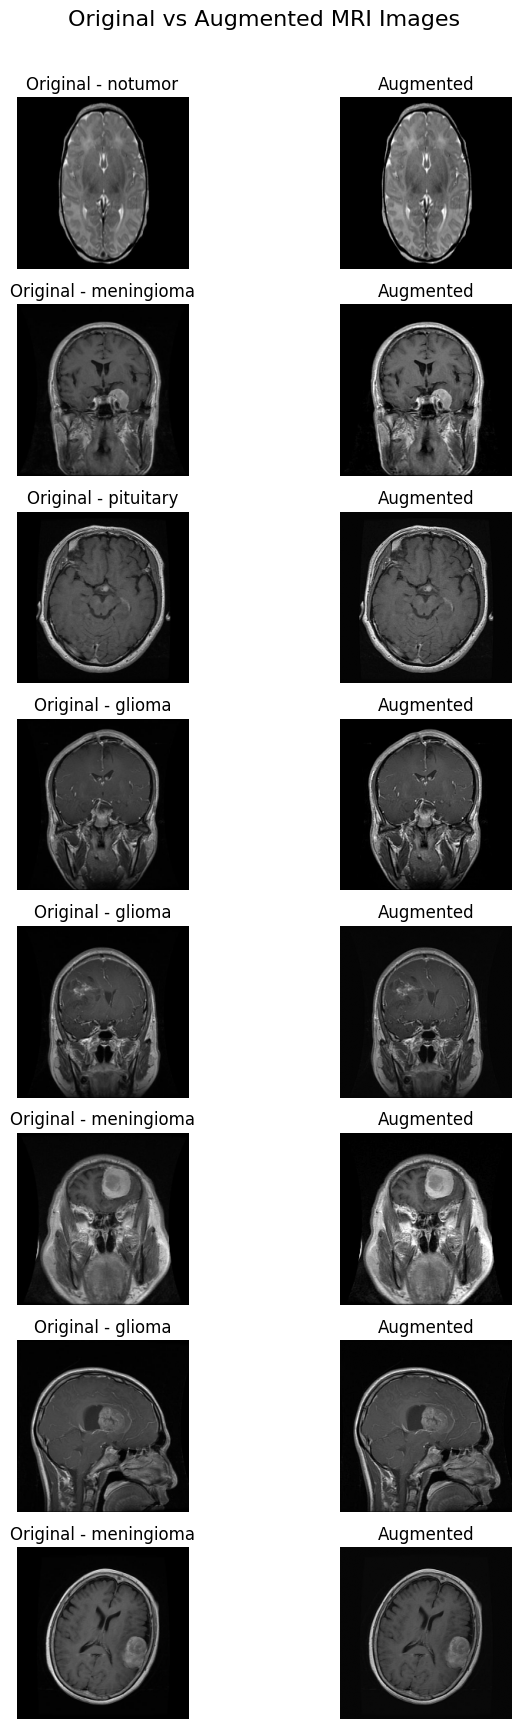

In [11]:
def visualize_augmented_samples(data_list, labels, num_samples=8):
    """
    Visualizes original vs augmented MRI samples side-by-side.

    Args:
        data_list: List of (image_path, label)
        labels: List of label names (same order as data_list)
        num_samples: Number of samples to show (will show 2*num_samples images)
    """
    assert num_samples <= len(data_list), "num_samples exceeds available data"
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 2.2))

    for i in range(num_samples):
        img_path, label = data_list[i]

        # Load augmented and original versions
        augmented_img = load_and_preprocess_image(img_path, augment=True)
        original_img = load_and_preprocess_image(img_path, augment=False)

        # Ensure pixel values are in range [0,1] for imshow
        augmented_img = np.clip(augmented_img, 0, 1)
        original_img = np.clip(original_img, 0, 1)

        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original - {label}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(augmented_img)
        axes[i, 1].set_title("Augmented")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.suptitle("Original vs Augmented MRI Images", fontsize=16)
    plt.subplots_adjust(top=0.93)  # Leave space for title
    plt.show()

# Show some augmented samples
visualize_augmented_samples(Train[:8], Train_labels[:8])

# Step 2: Build VGG16 Model

In [12]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

I0000 00:00:1753089798.222621      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753089798.223293      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

## 📋 Explanation of Each Layer:
| Layer                            | Description                                                                                                         |
| -------------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| `base_model`                     | Pretrained VGG16 model (excluding top layers), used for feature extraction.                                         |
| `GlobalAveragePooling2D()`       | Reduces each feature map to a single number by taking the average, flattening the output.                           |
| `Dense(256, activation='relu')`  | Fully connected layer with 256 neurons and ReLU activation for learning complex patterns.                           |
| `BatchNormalization()`           | Normalizes the activations to stabilize and speed up training.                                                      |
| `Dropout(0.5)`                   | Regularization layer to prevent overfitting by randomly deactivating 50% of neurons during training.                |
| `Dense(4, activation='softmax')` | Final classification layer with 4 outputs for the brain tumor classes: glioma, meningioma, no tumor, and pituitary. |


In [ ]:
model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(4, activation='softmax', kernel_initializer='glorot_uniform')
])

## 📌 Explanation:

| Component                       | Description                                                                                     |
| ------------------------------- | ----------------------------------------------------------------------------------------------- |
| `SGD`                           | Stochastic Gradient Descent optimizer used for training.                                        |
| `learning_rate=0.01`            | Controls how much to update the model in response to the estimated error.                       |
| `momentum=0.9`                  | Helps accelerate SGD in the right direction and dampens oscillations.                           |
| `nesterov=True`                 | Enables Nesterov momentum for more accurate updates.                                            |
| `SparseCategoricalCrossentropy` | Used as the loss function since labels are encoded as integers (not one-hot).                   |
| `from_logits=False`             | Indicates that the output is a probability distribution (softmax is applied in the last layer). |
| `metrics=['accuracy']`          | Tracks accuracy during training and validation.                                                 |


In [29]:
optimizer = SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(
        from_logits=False,
    ),
    metrics=['accuracy']
)

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,068 (56.64 MB)

 Trainable params: 7,212,292 (27.51 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

In [31]:
gc.collect()

1605

In [32]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=NUM_EPOCHS,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 61s 319ms/step - accuracy: 0.9413 - loss: 0.1910 - val_accuracy: 0.9108 - val_loss: 0.2754
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - accuracy: 0.9805 - loss: 0.0566 - val_accuracy: 0.8040 - val_loss: 0.8601
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 282ms/step - accuracy: 0.9879 - loss: 0.0291 - val_accuracy: 0.9687 - val_loss: 0.1357
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - accuracy: 0.9848 - loss: 0.0412 - val_accuracy: 0.9031 - val_loss: 0.3282
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 285ms/step - accuracy: 0.9850 - loss: 0.0379 - val_accuracy: 0.9428 - val_loss: 0.1647
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - accuracy: 0.9849 - loss: 0.0399 - val_accuracy: 0.9375 - val_loss: 0.3299
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - accuracy: 0.9938 - loss: 0.0231 - val_accuracy: 0.9237 - val_loss: 0.2830
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - accuracy: 0.9945 - loss: 0

In [33]:
y_pred_probs = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step


In [34]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9855


In [36]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

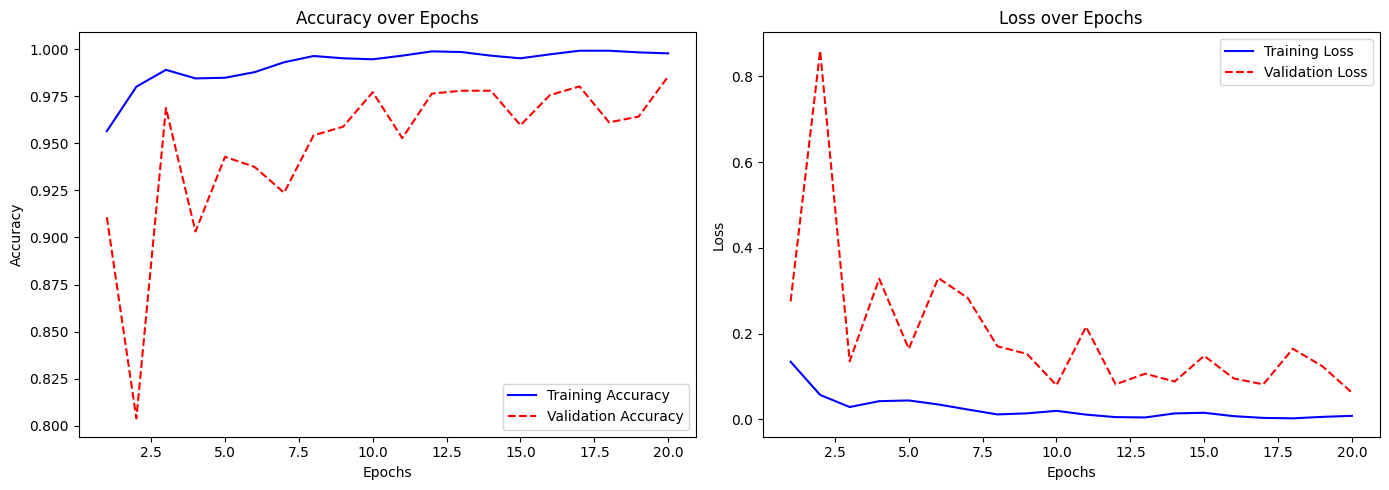

In [37]:
plot_training_history(history)

In [40]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

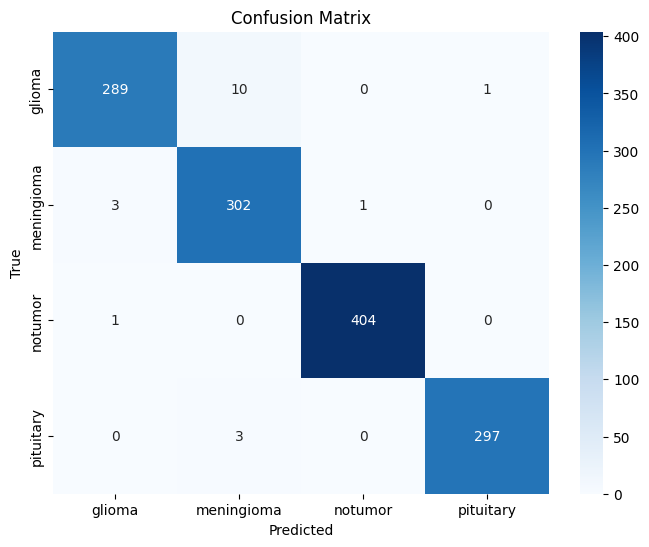

In [42]:
plot_confusion_matrix(y_test, y_pred, class_names=['glioma', 'meningioma', 'notumor', 'pituitary'])

In [47]:
print(classification_report(y_test, y_pred, target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))

              precision    recall  f1-score   support

      glioma       0.99      0.96      0.97       300
  meningioma       0.96      0.99      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311

